In [219]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
from cmath import nan
import json

from scipy import stats


In [220]:
#define the relevant path to the current batch you wish to parse
gap_name='pilot_one_week' #dont change this as this parsing sciprt only handles the same day batches.  

project_name='birds'
experiment_name='experiment 1'
batch_name='batch 2'
qualification_method='loose' #or 'loose'  - defines different disqualification criterions (add this suffix to the saved file)
PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' / gap_name / batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual-memory-project\projects\birds\experiment 1\collected data\pilot_one_week\batch 2


In [221]:

qualification_name_for_testin='UPDATE-eligible for testing 1 week birds' #note that the -space- after the title is improtant as for some reason this is how the qualification name is defined
qualification_name_for_entire_experiment='UPDATE-completed birds memory rep'



In [222]:
def set_criterions(type='strict'):
    #the function sets the criterions and returns them as a pd.series
    criterions_df=pd.Series(dtype=float)

    #update the non changing ciretrions: 
    criterions_df['demo_arrow_correctness']=1
    criterions_df['encoding_arrow_accuracy']=0.6
    criterions_df['longest_allowed_consequtive_strike']=15
    criterions_df['fast_threshold']=0.3

    if type=='strict':
        criterions_df['demo_accuracy_treshold']=0.5 
        
        criterions_df['fast_allowed_count']=3 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        criterions_df['binom_single_layer']=0.75
        criterions_df['binom_averages']=0.61
    elif type=='loose': #here we change things to be easier to pass
        criterions_df['demo_accuracy_treshold']=0
        criterions_df['fast_threshold']=0.3
        criterions_df['fast_allowed_count']=5 
        criterions_df['slow_threshold']=15
        criterions_df['slow_allowed_count']=5
        criterions_df['binom_single_layer']=0.55
        criterions_df['binom_averages']=0.55
    else: 
        raise Exception('requested method is not defined')
    
    return criterions_df


In [223]:

criterions_df=set_criterions(qualification_method)
criterions_df

demo_arrow_correctness                 1.00
encoding_arrow_accuracy                0.60
longest_allowed_consequtive_strike    15.00
fast_threshold                         0.30
demo_accuracy_treshold                 0.00
fast_allowed_count                     5.00
slow_threshold                        15.00
slow_allowed_count                     5.00
binom_single_layer                     0.55
binom_averages                         0.55
dtype: float64

In [224]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 
shelf_dict_after_test_name=PATH_TO_BATCH / 'shelf after test session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict


{'A21UA6O7ZFAIQJ': [33, 1672618541424, 1673265610931],
 'ABVBYS63BZWZ6': [54, 1672691441654, 1673184321835, 1673268961032],
 'AN4P0SU1YSPF2': [30,
  1672608091759,
  1673108004931,
  1673115273107,
  1673136507681,
  1673150501613,
  1673188398470],
 'AOOLS8280CL0Z': [7,
  1672601000146,
  1673111749669,
  1673137735525,
  1673185641801],
 'A2I6ZALE49CVSC': [0, 1673367367444],
 'A1TPGXT718D68E': [1, 1673367560992, 1673967969504],
 'A2MOU3YD664C0H': [2, 1673367619383, 1673972085784],
 'A2LA3NEWBU30QT': [3, 1673367650470, 1673965164358],
 'A3DP9IH8W5OXJL': [4, 1673367667732, 1673965034927],
 'AMAEYJH3DWA1V': [5, 1673367724382, 1673965103875],
 'AYCD7UMZHW4WD': [999, 1673367821150],
 'ATH176GTV3ABP': [999, 1673368064110, 1674099454320],
 'A1M1W56A3UR5PE': [9, 1673368158334],
 'A3S3WYVCVWW8IZ': [10, 1673368196632, 1673966299761],
 'A21ZYNCWJLHMCY': [999, 999, 999],
 'A1SJLXB0XFCJ97': [999, 999, 999],
 'A2RSBH1E3TEESG': [11, 1673368592968, 1673967623892],
 'A3QO3HIV92H659': [12, 16733686879

In [225]:
#this section reads all the relevant files: 
if (PATH_TO_BATCH / 'Batch_encoding_batch_results.csv').exists():
    encoding_df=pd.read_csv(PATH_TO_BATCH / 'Batch_encoding_batch_results.csv')
else: 
    print(f'no "Batch_encoding_batch_results.csv" was found in data')

if (PATH_TO_BATCH / 'Batch_testing_batch_results.csv').exists():
    testing_df=pd.read_csv(PATH_TO_BATCH / 'Batch_testing_batch_results.csv')
else: 
    print(f'no "Batch_testing_batch_results.csv" was found in data (probably because only the encoding session finished)')
if (PATH_TO_BATCH / 'Batch_workers_after_test.csv').exists():
    workers_df=pd.read_csv(PATH_TO_BATCH / 'Batch_workers_after_test.csv')
else:
    print('No AMAZON worker list was found: please make sure to upload one and name it correctly')



In [226]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [227]:
def process_worker_results(PATH_TO_BATCH_DATA,subject_name,parse_type='encoding'):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']

    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan  

    if (parse_type=='encoding'):
        sub_demo_information=cur_sub[demo_columns]
        empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_information=sub_demo_information.drop(index=empty_inds)


        #extract the demo test columns: 
        sub_demo_test_information=cur_sub[demo_test_columns]
        empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

        demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan
        

    if (parse_type=='encoding') | (parse_type=='all'):
        sub_encoding_information=cur_sub[encoding_related_columns]
        #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
        end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
        sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
        #remove all the rows that precede the real encoding phase: 
        empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
        sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    if (parse_type=='test') | (parse_type=='all'):
    #extract real experiment TEST related information: 
        sub_test_information=cur_sub[test_related_columns].dropna()


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['demo_df']=demo_df
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['encoding_df']=sub_encoding_information
    if (parse_type=='test') | (parse_type=='all'):
        subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [228]:

#get all results with Encoding information - extract the arrow attention check accuracy and RT (RT is currently not usd as a criterion)

#this section extract the list of participants from the downloaded results files (and not via the workers or session list csvs) 
# - it will create the qualification_df (a table with information on the worker ids and encoding behavior of all participants that we have files for)
all_filenames=[file for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name]
#print(f'current csv files:\n{all_filenames}')

qualification_for_test_df=pd.DataFrame(columns=['workerID','arrow_acc','mean_arrow_RT'])
for subject_csv in all_filenames:
    print(subject_csv.name)
    subject_dict=process_worker_results(PATH_TO_BATCH_DATA,path.Path(subject_csv))
    cur_sub_encoding=subject_dict['encoding_df']

    sname=subject_csv.name.split('_')[1] #change according to actuall format. 

    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all
        arrow_acc=0
        RT=nan
    else: 
        RT=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_acc=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
    sub_df=pd.DataFrame({'workerID':sname,'arrow_acc':arrow_acc,'mean_arrow_RT':RT},index=[sname])
    qualification_for_test_df=pd.concat([qualification_for_test_df,sub_df],axis=0)

#the following part update the qualification_df with information on wether the participant id exists in the amazon workers list: 

#change participants qualifications if they exists in the workers list based on thier encoding arrow accuracy
qualification_for_test_df['in_encoding_workers_list']=nan

for curr_worker_ID in qualification_for_test_df.index:
    if curr_worker_ID in encoding_df['WorkerId'].values:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(1)
    else:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(0)


ENCODING_A1122EUMFXHF38_2023-01-11_01h21.00.118.csv
ENCODING_A1EH9BPKYXFBS5_2023-01-10_18h23.37.843.csv
ENCODING_A1I5KX8TP3K5L2_2023-01-10_12h54.42.659.csv
ENCODING_A1OQFPHKZV0LM5_2023-01-10_13h24.55.245.csv
ENCODING_A1P2XKONWAOXHP_2023-01-10_14h05.53.473.csv
ENCODING_A1T2JRYTUVUD2O_2023-01-10_08h57.09.871.csv
ENCODING_A1T6TTD7XCUHOU_2023-01-11_08h34.21.242.csv
ENCODING_A1TPGXT718D68E_2023-01-10_11h19.20.992.csv
ENCODING_A1VBA5TN6G265Q_2023-01-11_03h03.24.384.csv
ENCODING_A1Y07DW8W2UXSD_2023-01-11_07h58.35.902.csv
ENCODING_A1YC558J4E5KZ_2023-01-10_22h18.54.330.csv
ENCODING_A208AK4JNI6PZ0_2023-01-10_23h25.31.197.csv
ENCODING_A249ZABI42JTSS_2023-01-11_09h09.29.039.csv
ENCODING_A28P7V6WDT9UN1_2023-01-11_10h11.33.435.csv
ENCODING_A290Z6QAL17PQE_2023-01-11_08h47.53.189.csv
ENCODING_A2I6ZALE49CVSC_2023-01-10_10h16.07.444.csv
ENCODING_A2KLIBLDVDV144_2023-01-10_11h45.07.433.csv
ENCODING_A2L18Q7871EONK_2023-01-10_17h43.17.725.csv
ENCODING_A2LA3NEWBU30QT_2023-01-10_11h20.50.470.csv
ENCODING_A2MO

In [229]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()
all_filenames=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'TEST' in file.name]

for subject_test_filename in all_filenames:
    subject_name=subject_test_filename.split('_')[1]
    subject_encoding_filename=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name and subject_name in file.name][0]
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_encoding_filename,parse_type='encoding')
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_test_filename,parse_type='test')
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name



    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_BATCH / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_BATCH / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [230]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(np.unique(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 34.45, range: [25 - 60], 0.39% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [231]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,left,1.0,1.878,0.0,flower1.jpg,flower1_pair.jpg,left,A1122EUMFXHF38
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,right,1.0,2.233,1.0,flower2_pair.jpg,flower2.jpg,right,A1122EUMFXHF38
2,6,2.0,left.jpg,left,1.108,left,14.0,left,1.0,2.505,2.0,flower3.jpg,flower3_pair.jpg,left,A1122EUMFXHF38
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,right,0.0,2.031,3.0,flower4.jpg,flower4_pair.jpg,left,A1122EUMFXHF38
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,2.132,4.0,flower5_pair.jpg,flower5.jpg,right,A1122EUMFXHF38


In [232]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,BREWERS_BLACKBIRD_3.jpg,CAPE_LONGCLAW_2.jpg,3.0,NaN,NaN,NaN,A1122EUMFXHF38
1,21,NaN,1.0,1.0,PYGMY_KINGFISHER_5.jpg,MASKED_BOOBY_5.jpg,2.0,NaN,NaN,NaN,A1122EUMFXHF38
2,22,NaN,1.0,2.0,OCELLATED_TURKEY_1.jpg,AMERICAN_PIPIT_1.jpg,2.0,NaN,NaN,NaN,A1122EUMFXHF38
3,23,NaN,1.0,3.0,WHITE_CHEEKED_TURACO_5.jpg,NORTHERN_MOCKINGBIRD_4.jpg,1.0,NaN,NaN,NaN,A1122EUMFXHF38
4,24,NaN,1.0,4.0,FLAME_BOWERBIRD_3.jpg,BROWN_THRASHER_4.jpg,2.0,NaN,NaN,NaN,A1122EUMFXHF38


In [233]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,2.0,right,left,0.0,2.246,0.0,0.0,0.0,0.0,1.0,AMERICAN_PIPIT_1.jpg,OCELLATED_TURKEY_1.jpg,A1122EUMFXHF38
1,3.0,left,right,0.0,1.854,0.0,1.0,1.0,1.0,1.0,AFRICAN_PIED_HORNBILL_5.jpg,CAPUCHINBIRD_2.jpg,A1122EUMFXHF38
2,3.0,right,right,1.0,1.598,0.0,2.0,2.0,2.0,1.0,WATTLED_LAPWING_3.jpg,HAWAIIAN_GOOSE_4.jpg,A1122EUMFXHF38
3,1.0,right,left,0.0,2.202,0.0,3.0,3.0,3.0,1.0,PEACOCK_2.jpg,BROWN_NOODY_3.jpg,A1122EUMFXHF38
4,3.0,right,right,1.0,1.705,0.0,4.0,4.0,4.0,1.0,BLACK_THROATED_BUSHTIT_1.jpg,CHUKAR_PARTRIDGE_5.jpg,A1122EUMFXHF38


In [234]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
A1122EUMFXHF38,1.1080,1.0,0.833333,2.101833,2.031000,2.116000
A1I5KX8TP3K5L2,1.1943,1.0,0.500000,1.893267,1.945200,1.841333
A1P2XKONWAOXHP,2.2121,1.0,0.666667,1.596817,1.636500,1.576975
A1T6TTD7XCUHOU,1.6770,1.0,0.833333,2.315167,1.645000,2.449200
A1TPGXT718D68E,0.6776,1.0,0.833333,1.806317,2.352800,1.697020
A1Y07DW8W2UXSD,1.1390,1.0,0.666667,1.474167,1.377000,1.522750
A1YC558J4E5KZ,0.5073,1.0,0.833333,2.193900,1.853400,2.262000
A249ZABI42JTSS,1.0199,1.0,0.666667,2.042283,2.324500,1.901175
A28P7V6WDT9UN1,0.8590,1.0,0.666667,1.210833,1.114000,1.259250
A290Z6QAL17PQE,1.1810,1.0,0.833333,1.439833,1.150000,1.497800


In [235]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A1122EUMFXHF38,1.009800,1.0
A1I5KX8TP3K5L2,1.258740,1.0
A1P2XKONWAOXHP,0.970920,1.0
A1T6TTD7XCUHOU,1.912750,0.8
A1TPGXT718D68E,1.272320,1.0
A1Y07DW8W2UXSD,1.250600,1.0
A1YC558J4E5KZ,0.581260,1.0
A249ZABI42JTSS,0.909800,0.6
A28P7V6WDT9UN1,0.988800,1.0
A290Z6QAL17PQE,1.270000,1.0


In [236]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))


#this code calculates response time averages (RT) exlcusing the trials that are TOO long: 
trial_too_long_exclusion_criteria=10


for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()

    # if there is one rt that is very long, lets not include it in the mean calculation 
    
    mean_rt=(test_match_df.loc[test_match_df['test_test_response.rt']<=trial_too_long_exclusion_criteria,'test_test_response.rt']).mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    cur_sub_testing_performence_copy=cur_sub_testing_performence.copy()
    cur_sub_testing_performence_copy.loc[cur_sub_testing_performence_copy['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
    correct_and_incorrect_rts=cur_sub_testing_performence_copy.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A1122EUMFXHF38,0.433333,1.633100,1.671588,1.582769,1.589650,0.40,1.546700,0.45,1.762950,0.45,11.0
A1I5KX8TP3K5L2,0.516667,2.166457,3.385755,1.886852,2.223270,0.70,2.112747,0.50,2.160363,0.35,3.0
A1P2XKONWAOXHP,0.566667,2.083470,2.026427,2.127091,1.970525,0.60,2.136015,0.35,2.143870,0.75,6.0
A1T6TTD7XCUHOU,0.683333,2.417356,2.520421,2.572927,2.613316,0.70,2.153600,0.70,2.494950,0.65,4.0
A1TPGXT718D68E,0.700000,1.652180,1.642933,1.656143,1.736375,0.65,1.573695,0.75,1.646470,0.70,5.0
A1Y07DW8W2UXSD,0.600000,1.534133,1.369500,1.643889,1.451450,0.60,1.441950,0.65,1.709000,0.55,7.0
A1YC558J4E5KZ,0.650000,2.279730,2.320081,2.258003,2.013655,0.70,2.618470,0.65,2.207065,0.60,5.0
A249ZABI42JTSS,0.516667,2.262347,2.263293,2.261461,2.272580,0.55,2.308035,0.55,2.206425,0.45,4.0
A28P7V6WDT9UN1,0.516667,1.371383,1.323379,1.416290,1.355250,0.60,1.353000,0.35,1.405900,0.60,5.0
A290Z6QAL17PQE,0.500000,1.426800,1.361833,1.491767,1.422650,0.65,1.486450,0.50,1.371300,0.35,3.0


In [237]:
cur_sub_testing_performence.loc[cur_sub_testing_performence['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
cur_sub_testing_performence

,correct,test_test_response.keys,test_test_response.rt,layer,test_test_response.corr
1800,left,right,2.192,3.0,0.0
1801,left,right,1.412,3.0,0.0
1802,right,left,1.193,3.0,0.0
1803,right,right,1.024,1.0,1.0
1804,right,right,1.301,1.0,1.0
1805,right,left,1.426,1.0,0.0
1806,left,left,1.165,1.0,1.0
1807,right,right,1.161,3.0,1.0
1808,left,right,1.548,2.0,0.0
1809,left,right,1.535,2.0,0.0


In [238]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [239]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)



#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 

#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=criterions_df['demo_arrow_correctness']
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>criterions_df['encoding_arrow_accuracy']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {criterions_df.demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {criterions_df.encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=criterions_df['binom_averages']) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_2_accuracy' ,'testing_layer_3_accuracy']]>=criterions_df['binom_single_layer']).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')


summary for criterions:
demo accuracy higher than 0.0 - qualified: 31
demo attention check correctness equals 1.0 - qualified: 31
experiment encoding attention check accuracy 0.6 - qualified: 29
experiment longest consequtive strike of maximum of  15.0 responses - qualified: 30
test too fast (thresold: 0.3, allowed count: 5.0 qualified: 29
test too slow (thresold: 15.0, allowed count: 5.0 qualified: 30
above chance accuracy in test, qualified: 29
OVERALL: number of qualified participants (adhere to all criterions): 24


In [240]:
data_df_for_analysis.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A1122EUMFXHF38,1.1080,1.0,0.833333,2.101833,2.0310,2.116000,1.00980,1.0,0.433333,1.633100,1.671588,1.582769,1.589650,0.40,1.546700,0.45,1.762950,0.45,11.0
A1I5KX8TP3K5L2,1.1943,1.0,0.500000,1.893267,1.9452,1.841333,1.25874,1.0,0.516667,2.166457,3.385755,1.886852,2.223270,0.70,2.112747,0.50,2.160363,0.35,3.0
A1P2XKONWAOXHP,2.2121,1.0,0.666667,1.596817,1.6365,1.576975,0.97092,1.0,0.566667,2.083470,2.026427,2.127091,1.970525,0.60,2.136015,0.35,2.143870,0.75,6.0
A1T6TTD7XCUHOU,1.6770,1.0,0.833333,2.315167,1.6450,2.449200,1.91275,0.8,0.683333,2.417356,2.520421,2.572927,2.613316,0.70,2.153600,0.70,2.494950,0.65,4.0
A1TPGXT718D68E,0.6776,1.0,0.833333,1.806317,2.3528,1.697020,1.27232,1.0,0.700000,1.652180,1.642933,1.656143,1.736375,0.65,1.573695,0.75,1.646470,0.70,5.0


In [241]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions],axis=1)
disqualification_df


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc
A1122EUMFXHF38,True,True,True,True,True,True,False
A1I5KX8TP3K5L2,True,True,True,True,True,True,True
A1P2XKONWAOXHP,True,True,True,True,True,True,True
A1T6TTD7XCUHOU,True,True,True,True,True,True,True
A1TPGXT718D68E,True,True,True,True,True,True,True
A1Y07DW8W2UXSD,True,True,True,True,True,True,True
A1YC558J4E5KZ,True,True,True,True,True,True,True
A249ZABI42JTSS,True,True,False,True,True,True,True
A28P7V6WDT9UN1,True,True,True,True,True,True,True
A290Z6QAL17PQE,True,True,True,True,True,True,True


In [242]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list

batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'inner')
batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1



In [243]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]
final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A1I5KX8TP3K5L2,1.1943,1.0,0.500000,1.893267,1.945200,1.841333,1.25874,1.0,0.516667,2.166457,3.385755,1.886852,2.223270,0.70,2.112747,0.50,2.160363,0.35,3.0
A1P2XKONWAOXHP,2.2121,1.0,0.666667,1.596817,1.636500,1.576975,0.97092,1.0,0.566667,2.083470,2.026427,2.127091,1.970525,0.60,2.136015,0.35,2.143870,0.75,6.0
A1T6TTD7XCUHOU,1.6770,1.0,0.833333,2.315167,1.645000,2.449200,1.91275,0.8,0.683333,2.417356,2.520421,2.572927,2.613316,0.70,2.153600,0.70,2.494950,0.65,4.0
A1TPGXT718D68E,0.6776,1.0,0.833333,1.806317,2.352800,1.697020,1.27232,1.0,0.700000,1.652180,1.642933,1.656143,1.736375,0.65,1.573695,0.75,1.646470,0.70,5.0
A1Y07DW8W2UXSD,1.1390,1.0,0.666667,1.474167,1.377000,1.522750,1.25060,1.0,0.600000,1.534133,1.369500,1.643889,1.451450,0.60,1.441950,0.65,1.709000,0.55,7.0
A1YC558J4E5KZ,0.5073,1.0,0.833333,2.193900,1.853400,2.262000,0.58126,1.0,0.650000,2.279730,2.320081,2.258003,2.013655,0.70,2.618470,0.65,2.207065,0.60,5.0
A28P7V6WDT9UN1,0.8590,1.0,0.666667,1.210833,1.114000,1.259250,0.98880,1.0,0.516667,1.371383,1.323379,1.416290,1.355250,0.60,1.353000,0.35,1.405900,0.60,5.0
A290Z6QAL17PQE,1.1810,1.0,0.833333,1.439833,1.150000,1.497800,1.27000,1.0,0.500000,1.426800,1.361833,1.491767,1.422650,0.65,1.486450,0.50,1.371300,0.35,3.0
A2LA3NEWBU30QT,1.6784,1.0,0.666667,0.751650,0.513200,0.870875,1.38888,1.0,0.500000,1.229433,1.128273,1.330593,1.136160,0.65,1.100470,0.35,1.451670,0.50,6.0
A2MOU3YD664C0H,1.0410,1.0,0.666667,3.341833,3.642000,3.191750,1.04620,1.0,0.500000,2.669217,2.836267,2.502167,2.662400,0.65,2.384500,0.40,2.960750,0.45,5.0


In [244]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A1122EUMFXHF38,1.1080,1.0,0.833333,2.101833,2.0310,2.116000,1.00980,1.0,0.433333,1.633100,...,0.45,11.0,True,True,True,True,True,True,False,A1122EUMFXHF38
A1I5KX8TP3K5L2,1.1943,1.0,0.500000,1.893267,1.9452,1.841333,1.25874,1.0,0.516667,2.166457,...,0.35,3.0,True,True,True,True,True,True,True,A1I5KX8TP3K5L2
A1P2XKONWAOXHP,2.2121,1.0,0.666667,1.596817,1.6365,1.576975,0.97092,1.0,0.566667,2.083470,...,0.75,6.0,True,True,True,True,True,True,True,A1P2XKONWAOXHP
A1T6TTD7XCUHOU,1.6770,1.0,0.833333,2.315167,1.6450,2.449200,1.91275,0.8,0.683333,2.417356,...,0.65,4.0,True,True,True,True,True,True,True,A1T6TTD7XCUHOU
A1TPGXT718D68E,0.6776,1.0,0.833333,1.806317,2.3528,1.697020,1.27232,1.0,0.700000,1.652180,...,0.70,5.0,True,True,True,True,True,True,True,A1TPGXT718D68E


In [245]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)



#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 

#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=criterions_df['demo_arrow_correctness']
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>criterions_df['encoding_arrow_accuracy']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {criterions_df.demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {criterions_df.encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=criterions_df['binom_averages']) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_2_accuracy' ,'testing_layer_3_accuracy']]>=criterions_df['binom_single_layer']).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')

c:\Users\d_abe\.conda\envs\my_env_v3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\d_abe\.conda\envs\my_env_v3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(365.48863636363626, 0.5, 'RT')

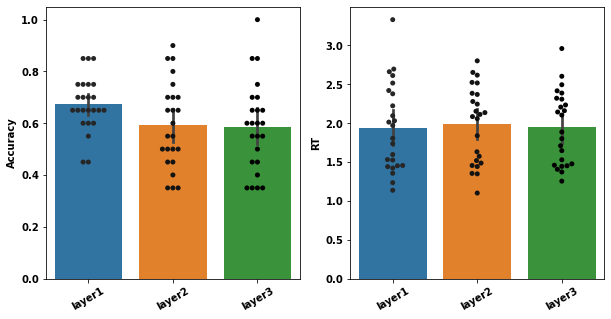

In [246]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

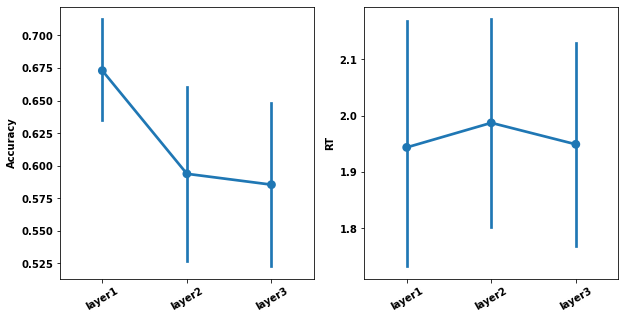

In [247]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


C:\Users\d_abe\AppData\Local\Temp\ipykernel_18196\2111522616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_participants_df['worker_ID'] = final_participants_df.index


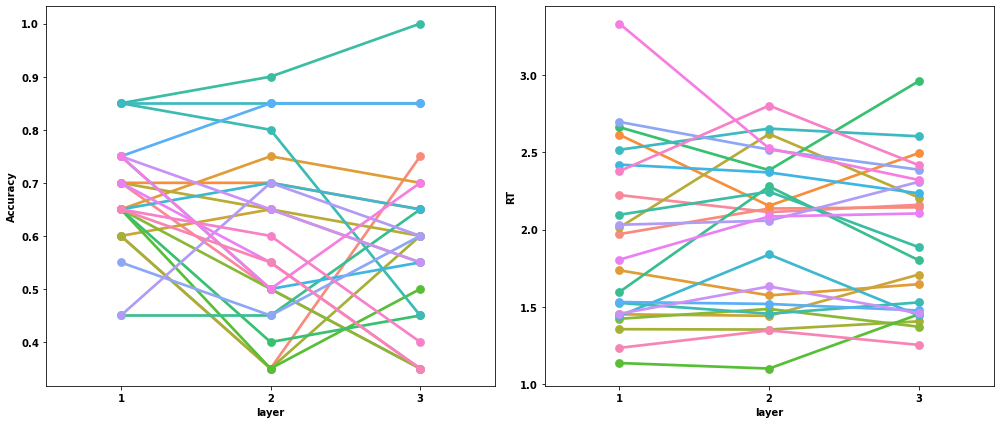

In [248]:
final_participants_df['worker_ID'] = final_participants_df.index
rt_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt'],var_name='layer')

accuracy_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy'],var_name='layer')


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)


#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,1,2],['1','2','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,1,2],['1','2','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

In [249]:
#this is the updated shelf: copy from here and place in the shelf location in pavlovia.org
new_shelf_dict=shelf_dict.copy()


clean_shelf_after_test=True #change to true if you run this code after completing both encoding and test sessions and want to also resert participants that didnt come back at all... 
if clean_shelf_after_test: 


    allowed_interval_in_hours=24
    allowed_jitter=3
    allowed_interval_in_ms=[allowed_interval_in_hours-allowed_jitter,allowed_interval_in_hours+allowed_jitter]*3600*1000


    new_shelf_dict=shelf_dict.copy()
    changed_keys_list=[]
    for key in new_shelf_dict.keys():
        print(key)
        cur_entries=new_shelf_dict[key]
        if len(cur_entries)==2: 
            cur_entries[0]=999
            changed_keys_list.append(key)

        if len(cur_entries)>2:
            encoding_time=cur_entries[1]
            last_entree=cur_entries[-1]
            if last_entree == None or encoding_time == None :
                last_entree = 999
                encoding_time = 999
            if (last_entree - encoding_time) < allowed_interval_in_ms[0]:
                cur_entries[0]=999
                changed_keys_list.append(key)


        new_shelf_dict[key]=cur_entries

    print('changed entrees for:',changed_keys_list)

    ##### print the updated shelf dictionary so you can copy it from the cell output and paste in the shelf:  (change the shelf only if you run this code after both encoding and TEST has ended) ####
    new_shelf_dict


A21UA6O7ZFAIQJ
ABVBYS63BZWZ6
AN4P0SU1YSPF2
AOOLS8280CL0Z
A2I6ZALE49CVSC
A1TPGXT718D68E
A2MOU3YD664C0H
A2LA3NEWBU30QT
A3DP9IH8W5OXJL
AMAEYJH3DWA1V
AYCD7UMZHW4WD
ATH176GTV3ABP
A1M1W56A3UR5PE
A3S3WYVCVWW8IZ
A21ZYNCWJLHMCY
A1SJLXB0XFCJ97
A2RSBH1E3TEESG
A3QO3HIV92H659
A1SJLXB0XFCJ92
A2T5CROJ0FWIJY
AV55CMG8KR1YH
A2OT9ZJC4MQBS8
A2KLIBLDVDV144
A2PAWE1NW4MD8L
A9500TJQDB94E
AQQE1W9R9KRYW
A1T2JRYTUVUD2O
A66QAY9ZC7PS4
A3EKR5FNVVN2CC
AW1EN7PL054OB
A2YK6945O0SP8N
A2R5ZHND3OQJAV
A1I5KX8TP3K5L2
A2OOYCMD4P4VFK
A34LSCB90T5KYE
A36BPBYVFDSNBB
A3D3FNUSK1A2P6
A1OQFPHKZV0LM5
A2OK9P9QCBZKMB
A1P2XKONWAOXHP
A2RWLFIP23FZA7
A30RAYNDOWQ61S
AT5LT9B0GKOIK
AAZNLKG9ZCL1N
A2L18Q7871EONK
A3S4HVPIEK0QQ3
A1XAL86XSJPFWK
A1EH9BPKYXFBS5
ATP0UFAVIANFL
AE681FG4LT6DV
AQN32EZB7OQRG
A1YC558J4E5KZ
A3G55RJTW3BSGM
A1122EUMFXHF38
A208AK4JNI6PZ0
A3NQWRK8KWTILX
AVSPYLB9KOHMX
A1VBA5TN6G265Q
ATUS3Q9I9EJNZ
A1T6TTD7XCUHOU
A290Z6QAL17PQE
A1Y07DW8W2UXSD
A249ZABI42JTSS
A28P7V6WDT9UN1
A309WI6Y258387
AI6M2CNDFUW3J
A3GHCTI04OQA1Y
changed entrees

In [250]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
new_shelf_dict  


# add the final state of the previous batch 
previous_batch = 'batch ' + str(int(batch_name[-1]) - 1)
root_dirs = list(PATH_TO_BATCH.parent.iterdir())
target_dir = PATH_TO_BATCH.parent/ previous_batch
if target_dir in root_dirs:
    path_final_state_shelf = target_dir / 'shelf final state.txt'
    with open(path_final_state_shelf) as f:
        data = f.read()
        shelf_dict = json.loads(data)
    
    new_shelf_dict = new_shelf_dict | shelf_dict

print('\n\ncopy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)

56 were given a UPDATE-completed birds memory rep, names: ['A21UA6O7ZFAIQJ', 'ABVBYS63BZWZ6', 'AN4P0SU1YSPF2', 'AOOLS8280CL0Z', 'A2I6ZALE49CVSC', 'A1TPGXT718D68E', 'A2MOU3YD664C0H', 'A2LA3NEWBU30QT', 'A3DP9IH8W5OXJL', 'AMAEYJH3DWA1V', 'AYCD7UMZHW4WD', 'ATH176GTV3ABP', 'A1M1W56A3UR5PE', 'A3S3WYVCVWW8IZ', 'A1SJLXB0XFCJ97', 'A2RSBH1E3TEESG', 'A3QO3HIV92H659', 'A2T5CROJ0FWIJY', 'A2OT9ZJC4MQBS8', 'A2KLIBLDVDV144', 'A2PAWE1NW4MD8L', 'A9500TJQDB94E', 'A1T2JRYTUVUD2O', 'A66QAY9ZC7PS4', 'A3EKR5FNVVN2CC', 'AW1EN7PL054OB', 'A2YK6945O0SP8N', 'A1I5KX8TP3K5L2', 'A2OOYCMD4P4VFK', 'A34LSCB90T5KYE', 'A36BPBYVFDSNBB', 'A3D3FNUSK1A2P6', 'A1OQFPHKZV0LM5', 'A2OK9P9QCBZKMB', 'A1P2XKONWAOXHP', 'A2RWLFIP23FZA7', 'A30RAYNDOWQ61S', 'AT5LT9B0GKOIK', 'AAZNLKG9ZCL1N', 'A2L18Q7871EONK', 'A1EH9BPKYXFBS5', 'ATP0UFAVIANFL', 'AQN32EZB7OQRG', 'A1YC558J4E5KZ', 'A3G55RJTW3BSGM', 'A1122EUMFXHF38', 'A208AK4JNI6PZ0', 'A3NQWRK8KWTILX', 'AVSPYLB9KOHMX', 'A1VBA5TN6G265Q', 'ATUS3Q9I9EJNZ', 'A1T6TTD7XCUHOU', 'A290Z6QAL17PQE', 'A1

'{"A1I5KX8TP3K5L2": [24, 1673373282659, 1673973237603], "A1P2XKONWAOXHP": [31, 1673377553473, 1673981181507, 1673982723492], "A1T6TTD7XCUHOU": [49, 1673444061242, 1673966443562, 1674013819839], "A1TPGXT718D68E": [1, 1673367560992, 1673967969504], "A1Y07DW8W2UXSD": [51, 1673445515902, 1674046980693], "A1YC558J4E5KZ": [41, 1673407134330, 1674015893631], "A28P7V6WDT9UN1": [53, 1673446293435, 1674047561527], "A290Z6QAL17PQE": [50, 1673444873189, 1674046484322], "A2LA3NEWBU30QT": [3, 1673367650470, 1673965164358], "A2MOU3YD664C0H": [2, 1673367619383, 1673972085784], "A2PAWE1NW4MD8L": [15, 1673369242776, 1673965462601], "A2RSBH1E3TEESG": [11, 1673368592968, 1673967623892], "A2RWLFIP23FZA7": [32, 1673382293069, 1673973513721], "A30RAYNDOWQ61S": [34, 1673382442986, 1673967015721], "A34LSCB90T5KYE": [25, 1673373897306, 1673984887533], "A3D3FNUSK1A2P6": [27, 1673374977494, 1673980617990], "A3DP9IH8W5OXJL": [4, 1673367667732, 1673965034927], "A3G55RJTW3BSGM": [42, 1673408338571, 1674013081449], "

In [251]:
batch_workers_df_extended.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))
